In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import genjax
from genjax import GenerativeFunction, ChoiceMap, Selection, trace

sns.set_theme(style="white")

# Pretty printing.
console = genjax.pretty(width=70)

# Reproducibility.
key = jax.random.PRNGKey(314159)

## What is GenJAX?

Here are a few high-level ways to think about GenJAX:

* A probabilistic programming system based on the concepts of [Gen](https://www.gen.dev/).

* A Bayesian model and inference compiler with support for device acceleration (courtesy of JAX).

* A base layer for experiments in model and inference DSL design.

There's already a well-supported implementation of [Gen in Julia](https://github.com/probcomp/Gen.jl). Why is a JAX port interesting?

There are a number of compelling technical and social reasons to explore Gen's probabilistic programming paradigm on top of JAX, here are a few:

* JAX's excellent accelerator support - our implementation natively supports several common accelerator idioms - like automatic struct-of-array representations, and the ability to automatically batch model/inference programs onto accelerators.

* JAX's excellent support for compositional AD removes implementation and maintenance complexity for Gen's gradient interfaces - previously a difficult challenge in other implementations. In addition, JAX's support for convenient, higher-order AD opens up new opportunities to explore during inference design with gradient interfaces.

* JAX exposes compositional code transformations to library authors, and, as library authors, we can utilize code transformations to implement state-of-the-art optimizations for models and inference expressed in our system.

* A lot of domain experts and modelers are working in Python! Some of them even use JAX (hopefully more each year). Presenting an interface to Gen which is familiar, and takes advantage of JAX's native ecosystem is a compelling social reason.

Let's truncate the list there for now.

For the JAX literati, one final (hopefully tantalizing) takeaway: <u>by construction, all GenJAX modeling + inference code is JAX traceable</u> - and thus, `vmap`able, `jit`able, etc.

## What is probabilistic programming?

Perhaps you may be coming to this notebook without any prior knowledge in probabilistic programming...

That's okay! Ideally, the ideas in this notebook should be self-contained^[You may miss _why generative functions (see below) are designed the way they are_ on a first read - but you'll still get the punchline if you follow the notebook to the end.].

### A Bayesian viewpoint

Here's one practical take on what probabilistic programming is all about: programming language design for expressing and solving Bayesian inference problems^[In the [Probabilistic Computing lab at MIT](http://probcomp.csail.mit.edu/), we also consider differentiable programming to be contained within the set of concerns of probabilistic programming. We won't cover differentiable programming interfaces in this notebook.]. 

There are other, more general, ways to say similar things (e.g. computational representations of operations on measures). Probabilistic programming is a broad field, and there are corners which may not be covered by our practical take. We'll just assume that people are interested in Bayes, and how to represent Bayes on computers in nice ways. For our purposes in this notebook, we'll stick as much as we can to the basics.

### What are we actually computing with?

The objects which we program with expose a mixture of generative and differentiable interfaces - the interfaces are designed to support common (as well as quite advanced) classes of Bayesian inference algorithms. Gen provides automation for the tricky math which these algorithms sometimes require.

We separate the design of inference (whose implementation uses the interfaces), from the implementation of the interfaces on computational objects. This allows us to build languages of objects which satisfy the interfaces - and allows their interoperability and usage.

In Gen, we call objects which implement the interfaces **generative functions**.

## What is a generative function?

Generative functions are the key concept of Gen's probabilistic programming paradigm. Generative functions are computational objects defined by a set of associated data types and methods. These types and methods describe compositional interfaces that are useful for Bayesian inference computations. 

Gen's formal description of generative functions consist of two objects:

* $P(\tau, r; x)$ - a normalized measure over tree-like data (*choice maps*) and untraced randomness^[More on this later. It's safe to say "I have no idea what that is" for now, and expect us to explain later or in another notebook.] $r$, parametrized by arguments $x$.

* $f(\tau; x)$ - a deterministic function from the above measure's sample space to a space of data types.

We can informally think of the sampling semantics of these objects as consisting of two steps:

1. First, sample a  choice map from $P$.
2. Then, compute the return value using $f$.

In many of the generative function interfaces, we won't just be interested in the final sampled return value. We'll also be interested in what happened along the way: we'll record the intermediate and final results of these steps in `Trace` objects - data structures which contain the recordings of values, along with probabilistic metadata like the score of random choices selected along the way.

Here's an example of a GenJAX generative function^[There's not just one generative function class - users can and are encouraged to design new types of generative functions which capture repeated modeling patterns. An excellent example of this modularity in Gen's design is [generative function combinators](/introduction/intro_to_combinators/intro_to_combinators).]. 

This generative function is part of a function-like language - pay close attention to the hierarchical compositionality of generative functions in this language under an abstraction (`genjax.trace`) similar to a function call. 

We'll discuss the addresses (`"sub"` and `"m0"`) a bit later.

In [2]:
@genjax.gen
def g(key, x):
    key, m0 = genjax.trace("m0", genjax.Bernoulli)(key, x)
    return (key, m0)


@genjax.gen
def h(key, x):
    key, m0 = genjax.trace("sub", g)(key, x)
    return (key, m0)


h

BuiltinGenerativeFunction
└── source
    └── <function h>

This generative function holds a Python `Callable` object. For this generative function language, the interface methods (see the list under **Generative function interface** below) which are useful for modeling and inference are given semantics via JAX's tracing and program transformation infrastructure.

Let's examine some of these operations now.

In [3]:
console.inspect(genjax.BuiltinGenerativeFunction, methods=True)

╭─ <class 'genjax.generative_functions.builtin.builtin_gen_fn.Builti─╮
│ class BuiltinGenerativeFunction(source: Callable) -> None:         │
│                                                                    │
│ BuiltinGenerativeFunction(source: Callable)                        │
│                                                                    │
│         assess = def assess(self, key, chm, args, **kwargs):       │
│        flatten = def flatten(self):                                │
│ get_trace_type = def get_trace_type(self, key, args, **kwargs):    │
│     importance = def importance(self, key, chm, args, **kwargs):   │
│       simulate = def simulate(self, key, args, **kwargs):          │
│      unflatten = def unflatten(data, xs):                          │
│          unzip = def unzip(self, key: jaxtyping.Integer[Array,     │
│                  '...'], fixed: genjax.core.datatypes.ChoiceMap)   │
│                  -> Tuple[jaxtyping.Integer[Array, '...'],         │
│                  Callable[[genjax.core.datatypes.ChoiceMap,        │
│                  Tuple], float],                                   │
│                  Callable[[genjax.core.datatypes.ChoiceMap,        │
│                  Tuple], Any]]:                                    │
│         update = def update(self, key, prev, new, args, **kwargs): │
╰────────────────────────────────────────────────────────────────────╯

This is our first glimpse of the **generative function interface** (GFI), the secret sauce which Gen is based around.

::: {.callout-note}

## JAX interfaces

There's a few methods here which are not part of the GFI, but are worth mentioning because they deal with data interfaces to JAX:

* `flatten` - which allows us to treat generative functions as [Pytree](https://jax.readthedocs.io/en/latest/pytrees.html) implementors.
* `unflatten` - same as above.

These are used to register the implementor type as a `Pytree`, which is roughly a tree-like Python structure which JAX can zip/unzip at runtime API boundaries.

:::

Let's study the `simulate` method first: we'll explore its semantics, and see the types of data it produces.

In [4]:
key, tr = genjax.simulate(h)(key, (0.3,))
tr

BuiltinTrace
├── gen_fn
│   └── BuiltinGenerativeFunction
│       └── source
│           └── <function h>
├── args
│   └── (0.3,)
├── retval
│   └── bool[]
├── choices
│   └── BuiltinChoiceMap
│       └── inner
│           └── HashableDict
│               └── sub
│                   └── BuiltinTrace
│                       ├── gen_fn
│                       │   └── BuiltinGenerativeFunction
│                       │       └── source
│                       │           └── <function g>
│                       ├── args
│                       │   └── (0.3,)
│                       ├── retval
│                       │   └── bool[]
│                       ├── choices
│                       │   └── BuiltinChoiceMap
│                       │       └── inner
│                       │           └── HashableDict
│                       │               └── m0
│                       │                   └── DistributionTrace
│                       │                       ├── gen_fn
│                       │                       │   └── _Bernoulli
│                       │                       ├── args
│                       │                       │   └── (0.3,)
│                       │                       ├── value
│                       │                       │   └── ValueChoiceMap
│                       │                       │       └── value
│                       │                       │           └── bool[]
│                       │                       └── score
│                       │                           └── f32[]
│                       ├── cache
│                       │   └── BuiltinTrie
│                       └── score
│                           └── f32[]
├── cache
│   └── BuiltinTrie
└── score
    └── f32[]

If you're familiar with other "trace-based" probabilistic systems - this should look familiar. 

This object instance is a piece of data which has captured information about the execution of the function. Specifically, the subtraces of _other generative function calls_ which occur in `genjax.trace` statements.

It also captures the `score` - the log probability of the normalized measure which the model program represents, evaluated at the random choices which the generative call execution produced. 

If you were paying attention above, the score is $\log P(\tau, r; x)$.

### How is `simulate` implemented for this language?

For this generative function language, we implement `simulate` using a code transformation! Here's the transformed code.

In [5]:
jaxpr = jax.make_jaxpr(genjax.simulate(h))(key, (0.3,))
jaxpr

{ lambda ; a:u32[2] b:f32[]. let
    c:key<fry>[] = random_wrap[impl=fry] a
    d:key<fry>[2] = random_split[count=2] c
    e:u32[2,2] = random_unwrap d
    f:u32[1,2] = slice[limit_indices=(1, 2) start_indices=(0, 0) strides=(1, 1)] e
    g:u32[2] = squeeze[dimensions=(0,)] f
    h:u32[1,2] = slice[limit_indices=(2, 2) start_indices=(1, 0) strides=(1, 1)] e
    i:u32[2] = squeeze[dimensions=(0,)] h
    j:key<fry>[] = random_wrap[impl=fry] i
    k:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    l:u32[] = random_bits[bit_width=32 shape=()] j
    m:u32[] = shift_right_logical l 9
    n:u32[] = or m 1065353216
    o:f32[] = bitcast_convert_type[new_dtype=float32] n
    p:f32[] = sub o 1.0
    q:f32[] = sub 1.0 0.0
    r:f32[] = mul p q
    s:f32[] = add r 0.0
    t:f32[] = reshape[dimensions=None new_sizes=()] s
    u:f32[] = max 0.0 t
    v:bool[] = lt u k
    w:f32[] = convert_element_type[new_dtype=float32 weak_type=True] v
    x:f32[] = sub w 0.0
    y:bool[] = ne x 0.0
    z:f32[] = xla_call[
      call_jaxpr={ lambda ; ba:bool[] bb:f32[] bc:f32[]. let
          bd:bool[] = convert_element_type[new_dtype=bool weak_type=False] ba
          be:f32[] = select_n bd bc bb
        in (be,) }
      name=_where
    ] y x 1.0
    bf:f32[] = xla_call[
      call_jaxpr={ lambda ; bg:bool[] bh:f32[] bi:f32[]. let
          bj:bool[] = convert_element_type[new_dtype=bool weak_type=False] bg
          bk:f32[] = select_n bj bi bh
        in (bk,) }
      name=_where
    ] y b 1.0
    bl:f32[] = log bf
    bm:f32[] = mul z bl
    bn:f32[] = xla_call[
      call_jaxpr={ lambda ; bo:bool[] bp:f32[] bq:f32[]. let
          br:bool[] = convert_element_type[new_dtype=bool weak_type=False] bo
          bs:f32[] = select_n br bq bp
        in (bs,) }
      name=_where
    ] y bm 0.0
    bt:f32[] = sub 1.0 x
    bu:f32[] = neg b
    bv:bool[] = ne bt 0.0
    bw:f32[] = xla_call[
      call_jaxpr={ lambda ; bx:bool[] by:f32[] bz:f32[]. let
          ca:bool[] = convert_element_type[new_dtype=bool weak_type=False] bx
          cb:f32[] = select_n ca bz by
        in (cb,) }
      name=_where
    ] bv bt 1.0
    cc:f32[] = xla_call[
      call_jaxpr={ lambda ; cd:bool[] ce:f32[] cf:f32[]. let
          cg:bool[] = convert_element_type[new_dtype=bool weak_type=False] cd
          ch:f32[] = select_n cg cf ce
        in (ch,) }
      name=_where
    ] bv bu 1.0
    ci:f32[] = log1p cc
    cj:f32[] = mul bw ci
    ck:f32[] = xla_call[
      call_jaxpr={ lambda ; cl:bool[] cm:f32[] cn:f32[]. let
          co:bool[] = convert_element_type[new_dtype=bool weak_type=False] cl
          cp:f32[] = select_n co cn cm
        in (cp,) }
      name=_where
    ] bv cj 0.0
    cq:f32[] = add bn ck
    cr:bool[] = lt x 0.0
    cs:bool[] = gt x 1.0
    ct:bool[] = convert_element_type[new_dtype=bool weak_type=False] cr
    cu:bool[] = convert_element_type[new_dtype=bool weak_type=False] cs
    cv:bool[] = or ct cu
    cw:f32[] = xla_call[
      call_jaxpr={ lambda ; cx:bool[] cy:f32[] cz:f32[]. let
          da:f32[] = select_n cx cz cy
        in (da,) }
      name=_where
    ] cv -inf cq
    db:f32[] = convert_element_type[new_dtype=float32 weak_type=False] cw
    dc:f32[] = reduce_sum[axes=()] db
    dd:f32[] = add 0.0 dc
    de:f32[] = add 0.0 dd
  in (g, b, v, b, v, b, v, dc, dd, de) }

That's a lot of code! This code is pure, numerical, and ready for acceleration. By utilizing JAX and a staging transformation, we've stripped out all Python overhead.

This is how we've implemented `simulate` for this particular generative function language.^[In general, Gen doesn't require that we follow the same "code transformation" implementation for other generative function languages. GenJAX, however, is a bit special - because we restrict the user to remain within the JAX traceable subset of Python - any generative function interface implementation must also be JAX traceable. **This is a JAX requirement, not a Gen one**.]

## Generative function interface

There are a few more generative function interface methods worth discussing.

In this notebook, instead of carefully walking through the math which these interface methods compute, we'll defer that discussion to another notebook. Below, we give an informal discussion of what each of the interface methods computes, and roughly describe what algorithm families are supported by their usage.

### The generative function interface in GenJAX

GenJAX's generative functions define an interface which support compositional usage of generative functions within other generative functions. The interface functions here closely mirror [the interfaces defined in Gen.jl](https://www.gen.dev/docs/stable/ref/gfi/#Generative-function-interface-1).

In the following, we use the following abbreviations:

* **IS** - importance sampling
* **SMC** - sequential Monte Carlo
* **MCMC** - Markov chain Monte Carlo
* **VI** - variational inference

| Interface | Type | Inference algorithm support |
| --- | --- | --- |
| `simulate` | Generative | IS, SMC |
| `importance` | Generative | IS, SMC, VI |
| `update` | Generative and incremental | MCMC, SMC |
| `assess` | Generative and differentiable | MCMC, IS, SMC |
| `unzip` | Differentiable | Differentiable and involutive MCMC and SMC, VI |

This interface supports several methods - I've roughly described them and split them into the two categories **Generative** and **Differentiable** below:

#### Generative

* `simulate` - sample from normalized trace measure, and return the score.
* `importance` - given constraints for some addresses, sample from unnormalized trace measure and return an importance weight.
* `update` - given an existing trace, and a set of constraints and argument change values, update the trace to be consistent with the set of constraints under execution with the new arguments, and return an incremental importance weight.
* `assess` - given a complete choice map and arguments, return the normalized log probability.


#### Differentiable

* `assess` - same as above.
* `unzip` - given a set of fixed constraints, return two callables. The first callable `score` accepts constraints which fill in the complement of the fixed constraints and arguments, and returns the normalized log probability of all the constraints. The second callable `retval` accepts constraints and arguments, and returns the return value for the generative function call consistent with the constraints and given arguments.

**unzip** produces two functions which can be compositionally used with `jax.grad` to evaluate gradients used by both differentiable and involutive MCMC and SMC.

## More about generative functions

Here are a few more bits of information which should help you gain context with these objects.

### Distributions are generative functions

In GenJAX, distributions are generative functions.

In [6]:
key, tr = genjax.simulate(genjax.Normal)(key, (0.0, 1.0))
tr

DistributionTrace
├── gen_fn
│   └── _Normal
├── args
│   └── (0.0, 1.0)
├── value
│   └── ValueChoiceMap
│       └── value
│           └── f32[]
└── score
    └── f32[]

This should bring a sigh of relief! Ah, distributions are generative functions - *the concepts can't be too exotic*.

Distributions implement the interface in a conceptually simple way. They don't have internal compositional choice structure (like the function-like `BuiltinGenerativeFunction` language above).

Distributions themselves expose two interfaces:

* `logpdf` - exact density evaluation.
* `sample` - exact sampling.

We can use these two interfaces to implement all the generative function interfaces for distributions.

### Associated data types

* **Choice maps** are the tree-like recordings of random choices in a trace.
* **Selection** is an object which allows querying a trace/choice map - selecting certain choices.

In [7]:
@genjax.gen
def h(key, x):
    key, m1 = genjax.trace("m0", genjax.Bernoulli)(key, x)
    key, m2 = genjax.trace("m1", genjax.Bernoulli)(key, x)
    return (key, m1 + m2)


key, tr = genjax.simulate(h)(key, (0.3,))
tr

BuiltinTrace
├── gen_fn
│   └── BuiltinGenerativeFunction
│       └── source
│           └── <function h>
├── args
│   └── (0.3,)
├── retval
│   └── bool[]
├── choices
│   └── BuiltinChoiceMap
│       └── inner
│           └── HashableDict
│               ├── m0
│               │   └── DistributionTrace
│               │       ├── gen_fn
│               │       │   └── _Bernoulli
│               │       ├── args
│               │       │   └── (0.3,)
│               │       ├── value
│               │       │   └── ValueChoiceMap
│               │       │       └── value
│               │       │           └── bool[]
│               │       └── score
│               │           └── f32[]
│               └── m1
│                   └── DistributionTrace
│                       ├── gen_fn
│                       │   └── _Bernoulli
│                       ├── args
│                       │   └── (0.3,)
│                       ├── value
│                       │   └── ValueChoiceMap
│                       │       └── value
│                       │           └── bool[]
│                       └── score
│                           └── f32[]
├── cache
│   └── BuiltinTrie
└── score
    └── f32[]

In [8]:
selection = genjax.select(["m1"])
selected, _ = selection.filter(tr.get_choices())
selected

BuiltinChoiceMap
└── inner
    └── HashableDict
        └── m1
            └── DistributionTrace
                ├── gen_fn
                │   └── _Bernoulli
                ├── args
                │   └── (0.3,)
                ├── value
                │   └── ValueChoiceMap
                │       └── value
                │           └── bool[]
                └── score
                    └── f32[]

## Great ... what can I do with them?

Now, we've informally seen the interfaces and datatypes associated with generative functions.

Studying the interfaces (and improvements thereof), as well as the computational objects which satisfy them can be an entire PhD's worth of effort. 

In the remainder of this notebook, let's see how we can do machine learning with them.

Let's consider a modeling problem where we wish to perform generalized regression with outliers between two variates, taking a family of polynomials as potential curves.

One such model for this data generating process is shown below.

In [9]:
# Two branches for a branching submodel.
@genjax.gen
def model_y(key, x, coefficients):
    basis_value = jnp.array([1.0, x, x**2])
    polynomial_value = jnp.sum(basis_value * coefficients)
    key, y = trace("value", genjax.Normal)(key, polynomial_value, 0.3)
    return key, y


@genjax.gen
def outlier_model(key, x, coefficients):
    basis_value = jnp.array([1.0, x, x**2])
    polynomial_value = jnp.sum(basis_value * coefficients)
    key, y = trace("value", genjax.Normal)(key, polynomial_value, 30.0)
    return key, y


# The branching submodel.
switch = genjax.SwitchCombinator([model_y, outlier_model])

# A mapped kernel function which calls the branching submodel.
@genjax.gen(genjax.MapCombinator, in_axes=(0, 0, None))
def kernel(key, x, coefficients):
    key, is_outlier = trace("outlier", genjax.Bernoulli)(key, 0.1)
    is_outlier = jnp.asarray(is_outlier, dtype=int)
    key, y = trace("y", switch)(key, is_outlier, x, coefficients)
    return key, y


@genjax.gen
def model(key, xs):
    key, coefficients = trace("alpha", genjax.MvNormal)(
        key, np.zeros(3), 2.0 * np.identity(3)
    )
    key, *sub_keys = jax.random.split(key, len(xs) + 1)
    sub_keys = jnp.array(sub_keys)
    _, ys = trace("ys", kernel)(sub_keys, xs, coefficients)
    return key, ys

There's a number of implementation patterns which you might pick up on by studying this model.

1. Generative functions explicitly pass a PRNG key in and out. This conforms to JAX's PRNG usage expectations.

2. To implement control flow, we use higher-order functions called combinators. These accept generative functions as input, and return generative functions as output.

3. Any JAX compatible code is allowed in the body of a generative function.

Courtesy of the interface, we get to design our `model` generative function in pieces. 

Now, let's examine the sampled observation address `("ys", "y")` from a sample trace from our model.

In [10]:
data = jnp.arange(0, 10, 0.5)
key, tr = jax.jit(model.simulate)(key, (data,))
tr["ys", "y"]

SwitchTrace
├── gen_fn
│   └── SwitchCombinator
│       └── branches
│           └── [
│                 BuiltinGenerativeFunction(source = <function model_y>),
│                 BuiltinGenerativeFunction(source = <function outlier_model>)
│               ]
├── chm
│   └── IndexedChoiceMap
│       ├── index
│       │   └── i32[20]
│       ├── BuiltinTrace
│       │   ├── gen_fn
│       │   │   └── BuiltinGenerativeFunction
│       │   │       └── source
│       │   │           └── <function model_y>
│       │   ├── args
│       │   │   └── (f32[20], f32[20,3])
│       │   ├── retval
│       │   │   └── f32[20]
│       │   ├── choices
│       │   │   └── BuiltinChoiceMap
│       │   │       └── inner
│       │   │           └── HashableDict
│       │   │               └── value
│       │   │                   └── DistributionTrace
│       │   │                       ├── gen_fn
│       │   │                       │   └── _Normal
│       │   │                       ├── args
│       │   │                       │   └── (f32[20], f32[20])
│       │   │                       ├── value
│       │   │                       │   └── ValueChoiceMap
│       │   │                       │       └── value
│       │   │                       │           └── f32[20]
│       │   │                       └── score
│       │   │                           └── f32[20]
│       │   ├── cache
│       │   │   └── BuiltinTrie
│       │   └── score
│       │       └── f32[20]
│       └── BuiltinTrace
│           ├── gen_fn
│           │   └── BuiltinGenerativeFunction
│           │       └── source
│           │           └── <function outlier_model>
│           ├── args
│           │   └── (f32[20], f32[20,3])
│           ├── retval
│           │   └── f32[20]
│           ├── choices
│           │   └── BuiltinChoiceMap
│           │       └── inner
│           │           └── HashableDict
│           │               └── value
│           │                   └── DistributionTrace
│           │                       ├── gen_fn
│           │                       │   └── _Normal
│           │                       ├── args
│           │                       │   └── (f32[20], f32[20])
│           │                       ├── value
│           │                       │   └── ValueChoiceMap
│           │                       │       └── value
│           │                       │           └── f32[20]
│           │                       └── score
│           │                           └── f32[20]
│           ├── cache
│           │   └── BuiltinTrie
│           └── score
│               └── f32[20]
├── args
│   └── (f32[20], f32[20,3])
├── retval
│   └── f32[20]
└── score
    └── f32[20]

Here, I'm just showing the subtrace from the switching model invocation - but it is already quite large and unwieldy!

Besides, it also doesn't tell us much about the values we truly care about here - the sampled values.

From this model, we can get these in two ways. 

The first way: we can just look at the trace return value.

In [11]:
tr.get_retval()

DeviceArray([   1.7448314 ,    0.41097283,   -1.9558886 ,   -5.498426  ,
               -9.625496  ,  -15.6570425 ,  -22.74233   ,  -30.96311   ,
              -30.182352  ,  -64.04883   ,  -62.844086  ,  -75.89779   ,
              -90.39219   , -105.64662   , -121.877945  , -140.97981   ,
             -159.82722   , -180.46971   , -207.86064   , -224.98926   ],            dtype=float32)

The second way: we can get them out of the choice map of the trace directly.

In [12]:
chm = tr.get_choices()
chm["ys", "y", "value"]

DeviceArray([   1.7448314 ,    0.41097283,   -1.9558886 ,   -5.498426  ,
               -9.625496  ,  -15.6570425 ,  -22.74233   ,  -30.96311   ,
              -30.182352  ,  -64.04883   ,  -62.844086  ,  -75.89779   ,
              -90.39219   , -105.64662   , -121.877945  , -140.97981   ,
             -159.82722   , -180.46971   , -207.86064   , -224.98926   ],            dtype=float32)

Now, let's construct a small visualization function to show us the samples.

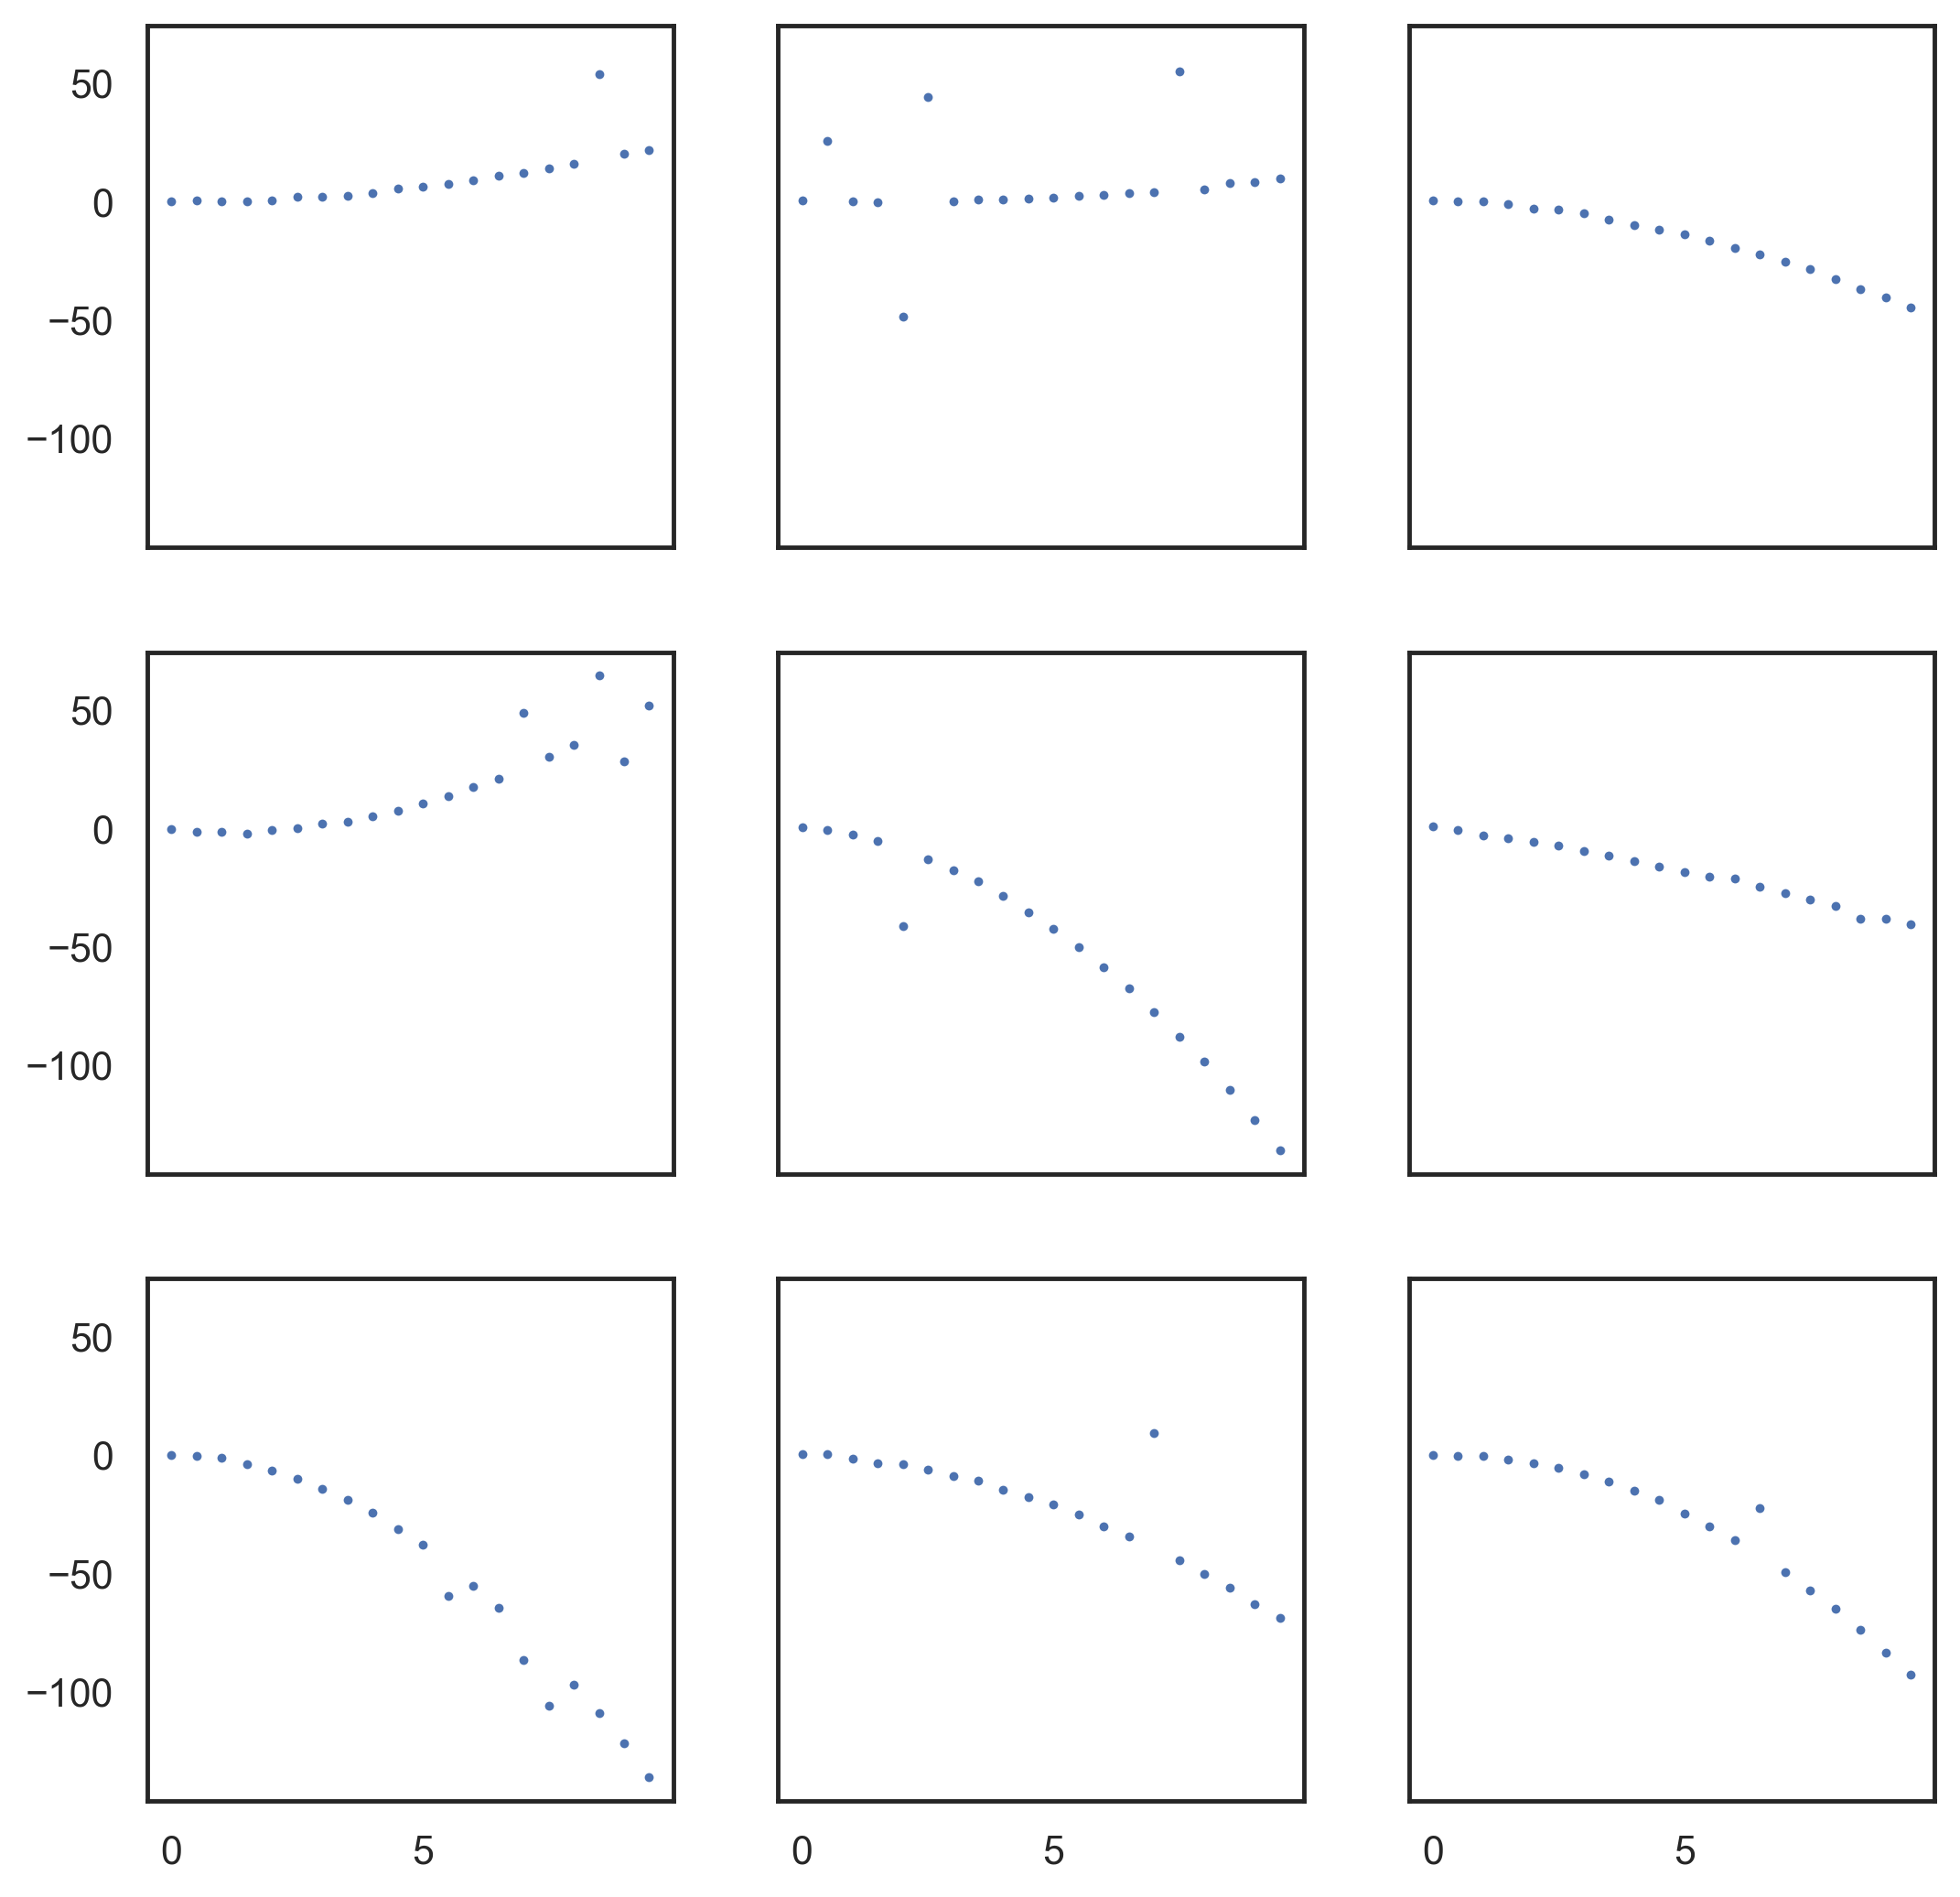

In [13]:
def viz(ax, x, y, **kwargs):
    (data,) = tr.get_args()
    chm = tr.get_choices()
    ys = np.array(chm["ys", "y", "value"])
    sns.scatterplot(x=x, y=y, ax=ax, **kwargs)


f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True, dpi=280)
jitted = jax.jit(model.simulate)
for ax in axes.flatten():
    key, tr = jitted(key, (data,))
    x = data
    y = tr.get_retval()
    viz(ax, x, y, marker=".")

plt.show()

Here's 9 samples from our model. 

We just walked through one of the main elements of probabilistic programming: setting up a program, which represents a joint distribution over random variates, some of which we'll identify with data we expect to see in the world.

We can adjust the noise settings of our model to produce wider priors over possible sets of points - and we may want to do this if our data is noisy!

For now, let's keep the settings as is, and explore inference in GenJAX.

## Your first inference program

Now, let's say we have some data.

In [14]:
x = np.array([0.3, 0.7, 1.1, 1.4, 2.3, 2.5, 3.0, 4.0, 5.0])
y = 2.0 * x + 1.5 + x**2
y[2] = 50.0

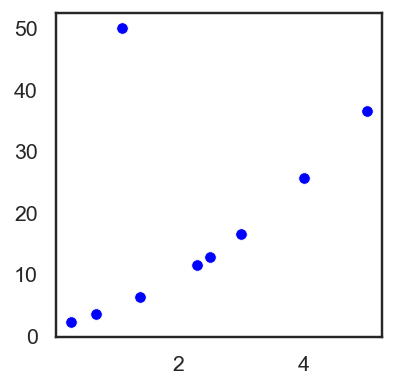

In [15]:
fig_data, ax_data = plt.subplots(figsize=(3, 3), dpi=140)
viz(ax_data, x, y, color="blue")

In Bayesian inference, if we wish to consider the conditional distribution $P(\tau, r; x | \text{data})$ induced from a model $P(\tau, \text{data}, r; x)$ - Bayes' rule gives us a way to compute it.

$$
P(\tau, r; x | \text{data}) = \frac{P(\tau, \text{data}, r; x)}{\int P(\tau, \text{data}, r; x) \ d\tau \ dr}
$$

The problem is that we often cannot compute the denominator (_the evidence integral_) easily. Instead, we turn to _approximate_ Bayesian inference.

Depending on how we wish to use the LHS conditional (which is called _the posterior_ in Bayesian inference) - we have different options available to us.

If we wish to approximately sample from the posterior, to get an empirical sense of its shape and properties, we will often utilize techniques which provide exact samplers for another distribution which gets asymptotically close to the target posterior if we increase certain hyperparameters.

One such algorithm is _importance sampling_, and that's what we'll write today.

Here's importance sampling (with a single sample) without a custom proposal in GenJAX.

In [16]:
observations = genjax.choice_map(
    {"ys": genjax.vector_choice_map(genjax.choice_map({("y", "value"): y}))}
)
model_args = (x,)
key, (w, tr) = model.importance(key, observations, model_args)

We're introduced to another interface method! 

`importance` accepts a PRNG key, a choice map representing observations (sometimes called constraints), and model arguments. It returns a new evolved PRNG key, and a tuple contained a log _importance weight_ and a trace.

The trace is consistent with the arguments and constraints passed into the invocation.

In [17]:
observations["ys", "y", "value"]

array([ 2.19,  3.39, 50.  ,  6.26, 11.39, 12.75, 16.5 , 25.5 , 36.5 ])

In [18]:
tr["ys", "y", "value"]

DeviceArray([ 2.19,  3.39, 50.  ,  6.26, 11.39, 12.75, 16.5 , 25.5 ,
             36.5 ], dtype=float32)

Let's examine the weight now, and compare it to the score.

In [19]:
(w, tr.get_score())

(DeviceArray(-10115.872, dtype=float32), DeviceArray(-10121.649, dtype=float32))

Notice that these two quantities are different. 

Remember: the score is the normalized log density of the choice map measure evaluated at the complete set of trace constraints. We'll refer to complete traces by $\tau$.

The log importance weight `w` is slightly different.

### Importance sampling ... informally

Let's discuss how importance sampling works first^[In this notebook, I'll defer discussing formal proofs concerning the asymptotic consistence of posterior estimators derived from importance sampling.].

This will provide us with an understanding as to why `w` is different from the `score`. 

More importantly, we'll understand how we can use `importance` to solve the inference task of approximately sampling from the posterior over coefficients (and ultimately, over curves) from our generative function.

::: {.callout-note}

Importance sampling is typically presented by focusing on posterior expectations $E_{x \sim P(x | y)}[f(x)]$.

In our case, we want to sample $x \sim P(x | y)$. To do this, we'll actually be considering a different procedure called *sampling importance resampling* or SIR for short.

Importantly, importance sampling is a subroutine in SIR. 

We'll discuss why importance sampling works here, and provide references to why SIR works to solve our problem.

:::

Let's start by considering two distributions which we can sample from, and evaluate densities.

Below, I'm plotting the densities of two distributions - a 1D Gaussian mixture and a 1D Gaussian^[GenJAX allows usage of TensorFlow Distributions as generative functions. Here, we're just using the `logpdf` interface from distributions which expose exact `logpdf` evaluation - but `genjax` exports a wrapper which implements the complete generative function interface.].

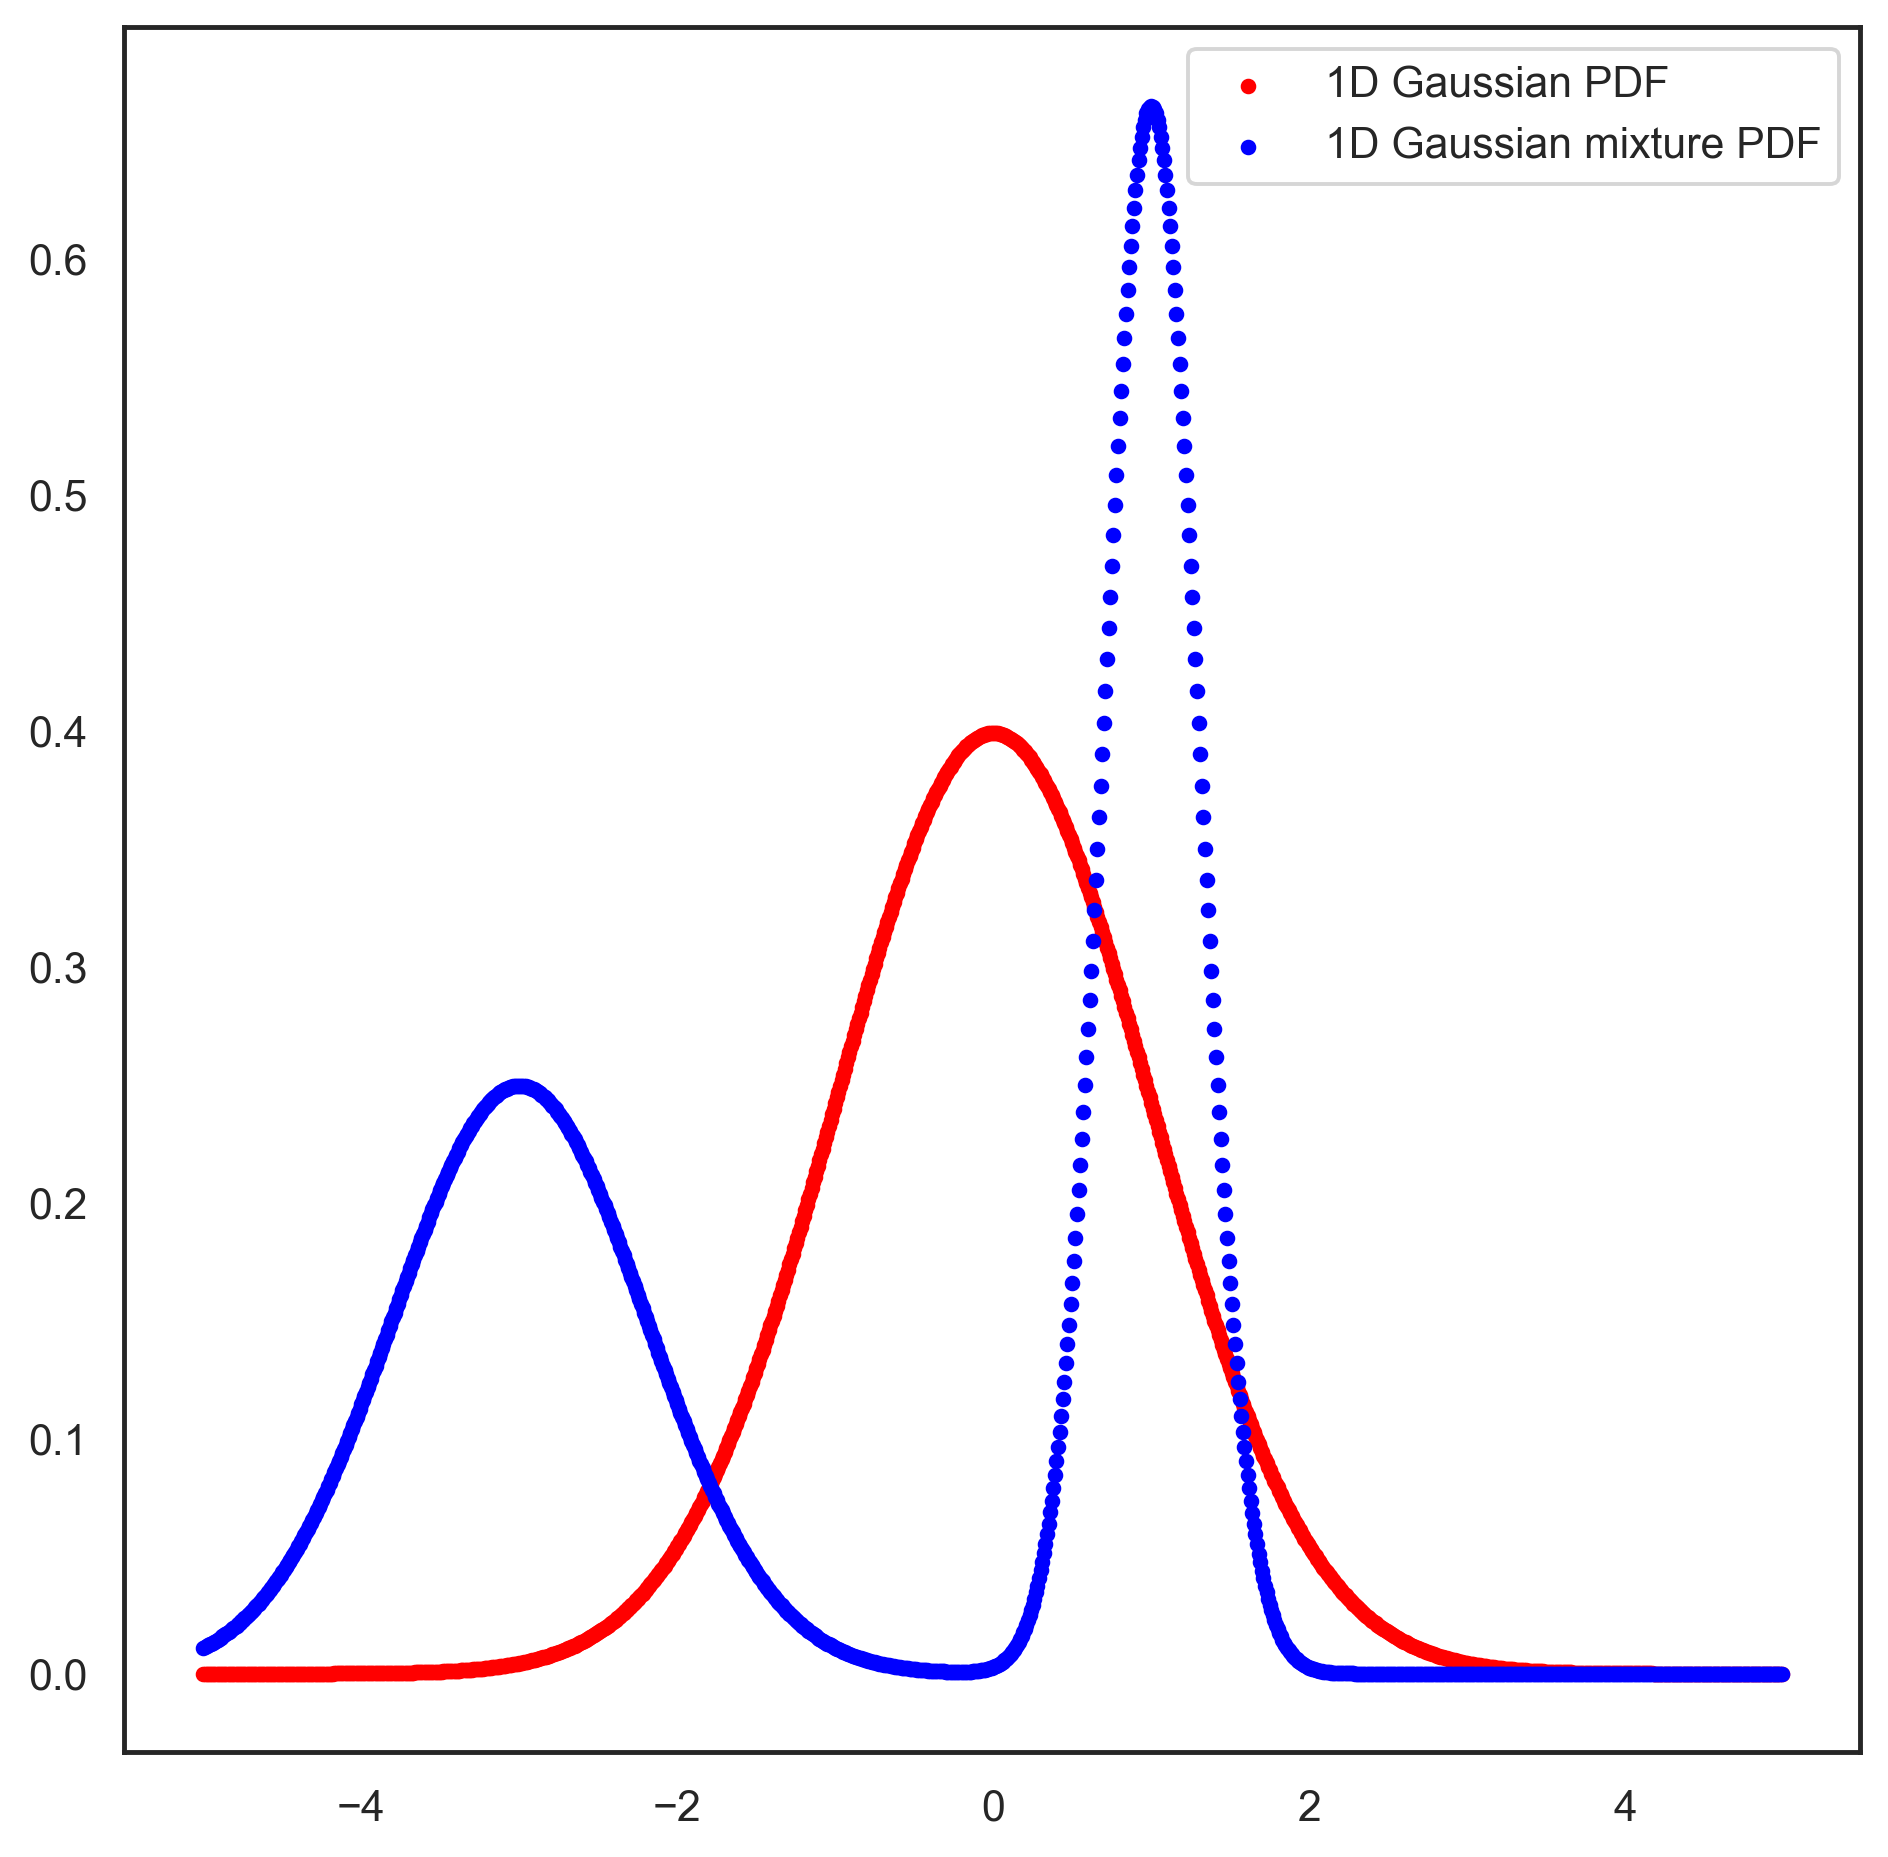

In [20]:
mix = genjax.TFPMixture(
    genjax.TFPCategorical, [genjax.TFPNormal, genjax.TFPNormal]
)
mix_args = ([0.5, 0.5], [(-3.0, 0.8), (1.0, 0.3)])
d = genjax.TFPNormal
d_args = (0.0, 1.0)


fig, ax = plt.subplots(figsize=(8, 8), dpi=280)
evaluation_points = np.arange(-5, 5, 0.01)


def plot_logpdf(ax, logpdf_fn, evaluation_points, **kwargs):
    logpdfs = jax.vmap(logpdf_fn)(evaluation_points)
    ax.scatter(evaluation_points, jnp.exp(logpdfs), marker=".", **kwargs)


d_logpdf = lambda v: d.logpdf(v, *d_args)
mix_logpdf = lambda v: mix.logpdf(v, *mix_args)

plot_logpdf(
    ax, d_logpdf, evaluation_points, color="red", label="1D Gaussian PDF"
)
plot_logpdf(
    ax,
    mix_logpdf,
    evaluation_points,
    color="blue",
    label="1D Gaussian mixture PDF",
)
ax.legend()

To gain context on importance sampling, imagine that the distribution which produces the blue curve is difficult to sample from - but it exposes a `logpdf` interface which we can use to evaluate the density at any point on the support of the distribution.

Now, suppose you hand me the distribution which made the red curve - and it is easy to sample from, and it also exposes a `logpdf` interface. 

One thing we could do is sample from the red curve and then "correct" for the fact that we're sampling from the wrong distribution.

This is the key intuition behind importance sampling.

Now, I'm going to write a procedure and ask you to just go with it ... for a moment.

In [21]:
def importance_sample(hard, easy):
    def _inner(key, hard_args, easy_args):
        key, sub_key = jax.random.split(key)
        sample = easy.sample(sub_key, *easy_args)
        easy_logpdf = easy.logpdf(sample, *easy_args)
        hard_logpdf = hard.logpdf(sample, *hard_args)
        importance_weight = hard_logpdf - easy_logpdf
        return key, (importance_weight, sample)

    return _inner

In [22]:
hard = genjax.TFPMixture(
    genjax.TFPCategorical, [genjax.TFPNormal, genjax.TFPNormal]
)
easy = genjax.TFPNormal
jitted = jax.jit(importance_sample(hard, easy))
key, (importance_weight, sample) = jitted(key, mix_args, d_args)

In [23]:
(importance_weight, sample)

(DeviceArray(-4.0058784, dtype=float32), DeviceArray(-0.78240925, dtype=float32))

Now, we can easily run this procedure many times in parallel.

In [24]:
jitted = jax.jit(
    jax.vmap(importance_sample(hard, easy), in_axes=(0, None, None))
)

In [25]:
key, *sub_keys = jax.random.split(key, 100 + 1)
sub_keys = jnp.array(sub_keys)
_, (importance_weight, sample) = jitted(sub_keys, mix_args, d_args)

In [26]:
importance_weight

DeviceArray([-6.2341752e+00,  6.2633801e-01, -3.3759670e+00,
             -5.9383879e+00, -9.7561479e-01, -5.3102112e+00,
             -5.1128283e+00, -2.1514070e+00,  4.5841384e-01,
             -4.0724092e+00, -1.8354319e+00, -5.5122299e+00,
             -6.2061067e+00, -2.1719730e-01, -3.5693016e+00,
             -6.1405115e+00, -5.3810544e+00, -6.2284150e+00,
              7.8095734e-01, -3.8515360e+00, -2.8184617e-01,
             -1.8381605e+00, -7.5211000e+00,  1.0577252e+00,
              1.0453278e+00,  1.0218762e+00,  9.8658347e-01,
              9.5912194e-01, -1.9758319e+00,  1.0580635e+00,
             -4.1381865e+00, -2.3692460e+00,  1.0351460e+00,
             -2.5306203e+00,  6.6269362e-01,  6.0733199e-02,
             -1.1496689e+00, -6.2260799e+00, -6.1138239e+00,
              4.6291578e-01, -4.1340222e+00,  8.6949825e-01,
             -2.1810038e+00, -2.9703891e+00, -7.1519613e-03,
             -1.2844566e+00, -2.3207369e+00, -2.3978152e+00,
             -1.0548264e+00, -5.6061153e+00, -5.9159632e+00,
             -3.1040215e-01, -1.5413404e-01, -1.2319851e-01,
             -1.4652884e+00, -5.0214028e-01,  6.9174856e-01,
             -5.8656144e+00, -5.3170371e+00,  6.0201246e-01,
             -1.6653061e-02, -3.0496669e+00, -2.3092539e+00,
             -2.4331427e+00,  1.0071430e+00, -5.6184292e+00,
             -1.1847696e+00, -3.5587354e+00, -5.8828015e+00,
             -3.7577522e+00, -3.6165695e+00, -5.5585594e+00,
             -1.7351907e+00, -6.7679203e-01,  1.9070494e-01,
             -3.9766405e+00,  5.7461774e-01, -1.0918140e-02,
             -2.6561151e+00,  4.9570715e-01,  6.3730204e-01,
              9.7846591e-01, -3.9247353e+00,  1.0440333e+00,
             -6.2158747e+00, -2.4731362e+00, -4.5478611e+00,
              1.0888841e+00, -7.3868978e-01, -4.2448354e+00,
              9.5782554e-01,  3.7766671e-01, -6.2152562e+00,
             -5.2021756e+00, -5.1431012e+00, -1.7538964e+00,
             -4.6911263e+00, -7.5708902e-01, -4.1147037e+00,
              9.9778765e-01], dtype=float32)

We're just sampling from `easy`, then scoring the samples with `importance_weight` according to the log ratio `easy_logpdf(sample) - hard_logpdf(sample)`.

Here's the trick - from our collection of samples and weights, let's normalize the weights into a distribution and sample a single sample to return using it.

In [27]:
def sampling_importance_resampling(hard, easy, n_samples):
    def _inner(key, hard_args, easy_args):
        fn = importance_sample(hard, easy)
        key, *sub_keys = jax.random.split(key, n_samples + 1)
        sub_keys = jnp.array(sub_keys)
        vmapped = jax.vmap(fn, in_axes=(0, None, None))
        _, (ws, samples) = vmapped(sub_keys, hard_args, easy_args)
        logits = ws
        key, sub_key = jax.random.split(key)
        index = genjax.TFPCategorical.sample(sub_key, logits)
        final_sample = samples[index]
        return key, final_sample

    return _inner

In [28]:
hard = genjax.TFPMixture(
    genjax.TFPCategorical, [genjax.TFPNormal, genjax.TFPNormal]
)
easy = genjax.TFPNormal
jitted = jax.jit(sampling_importance_resampling(hard, easy, 100))
key, sample = jitted(key, mix_args, d_args)

In [29]:
sample

DeviceArray(-2.556716, dtype=float32)

Let's run this procedure a bunch of times and plot the points on the x-axis of our plot above.

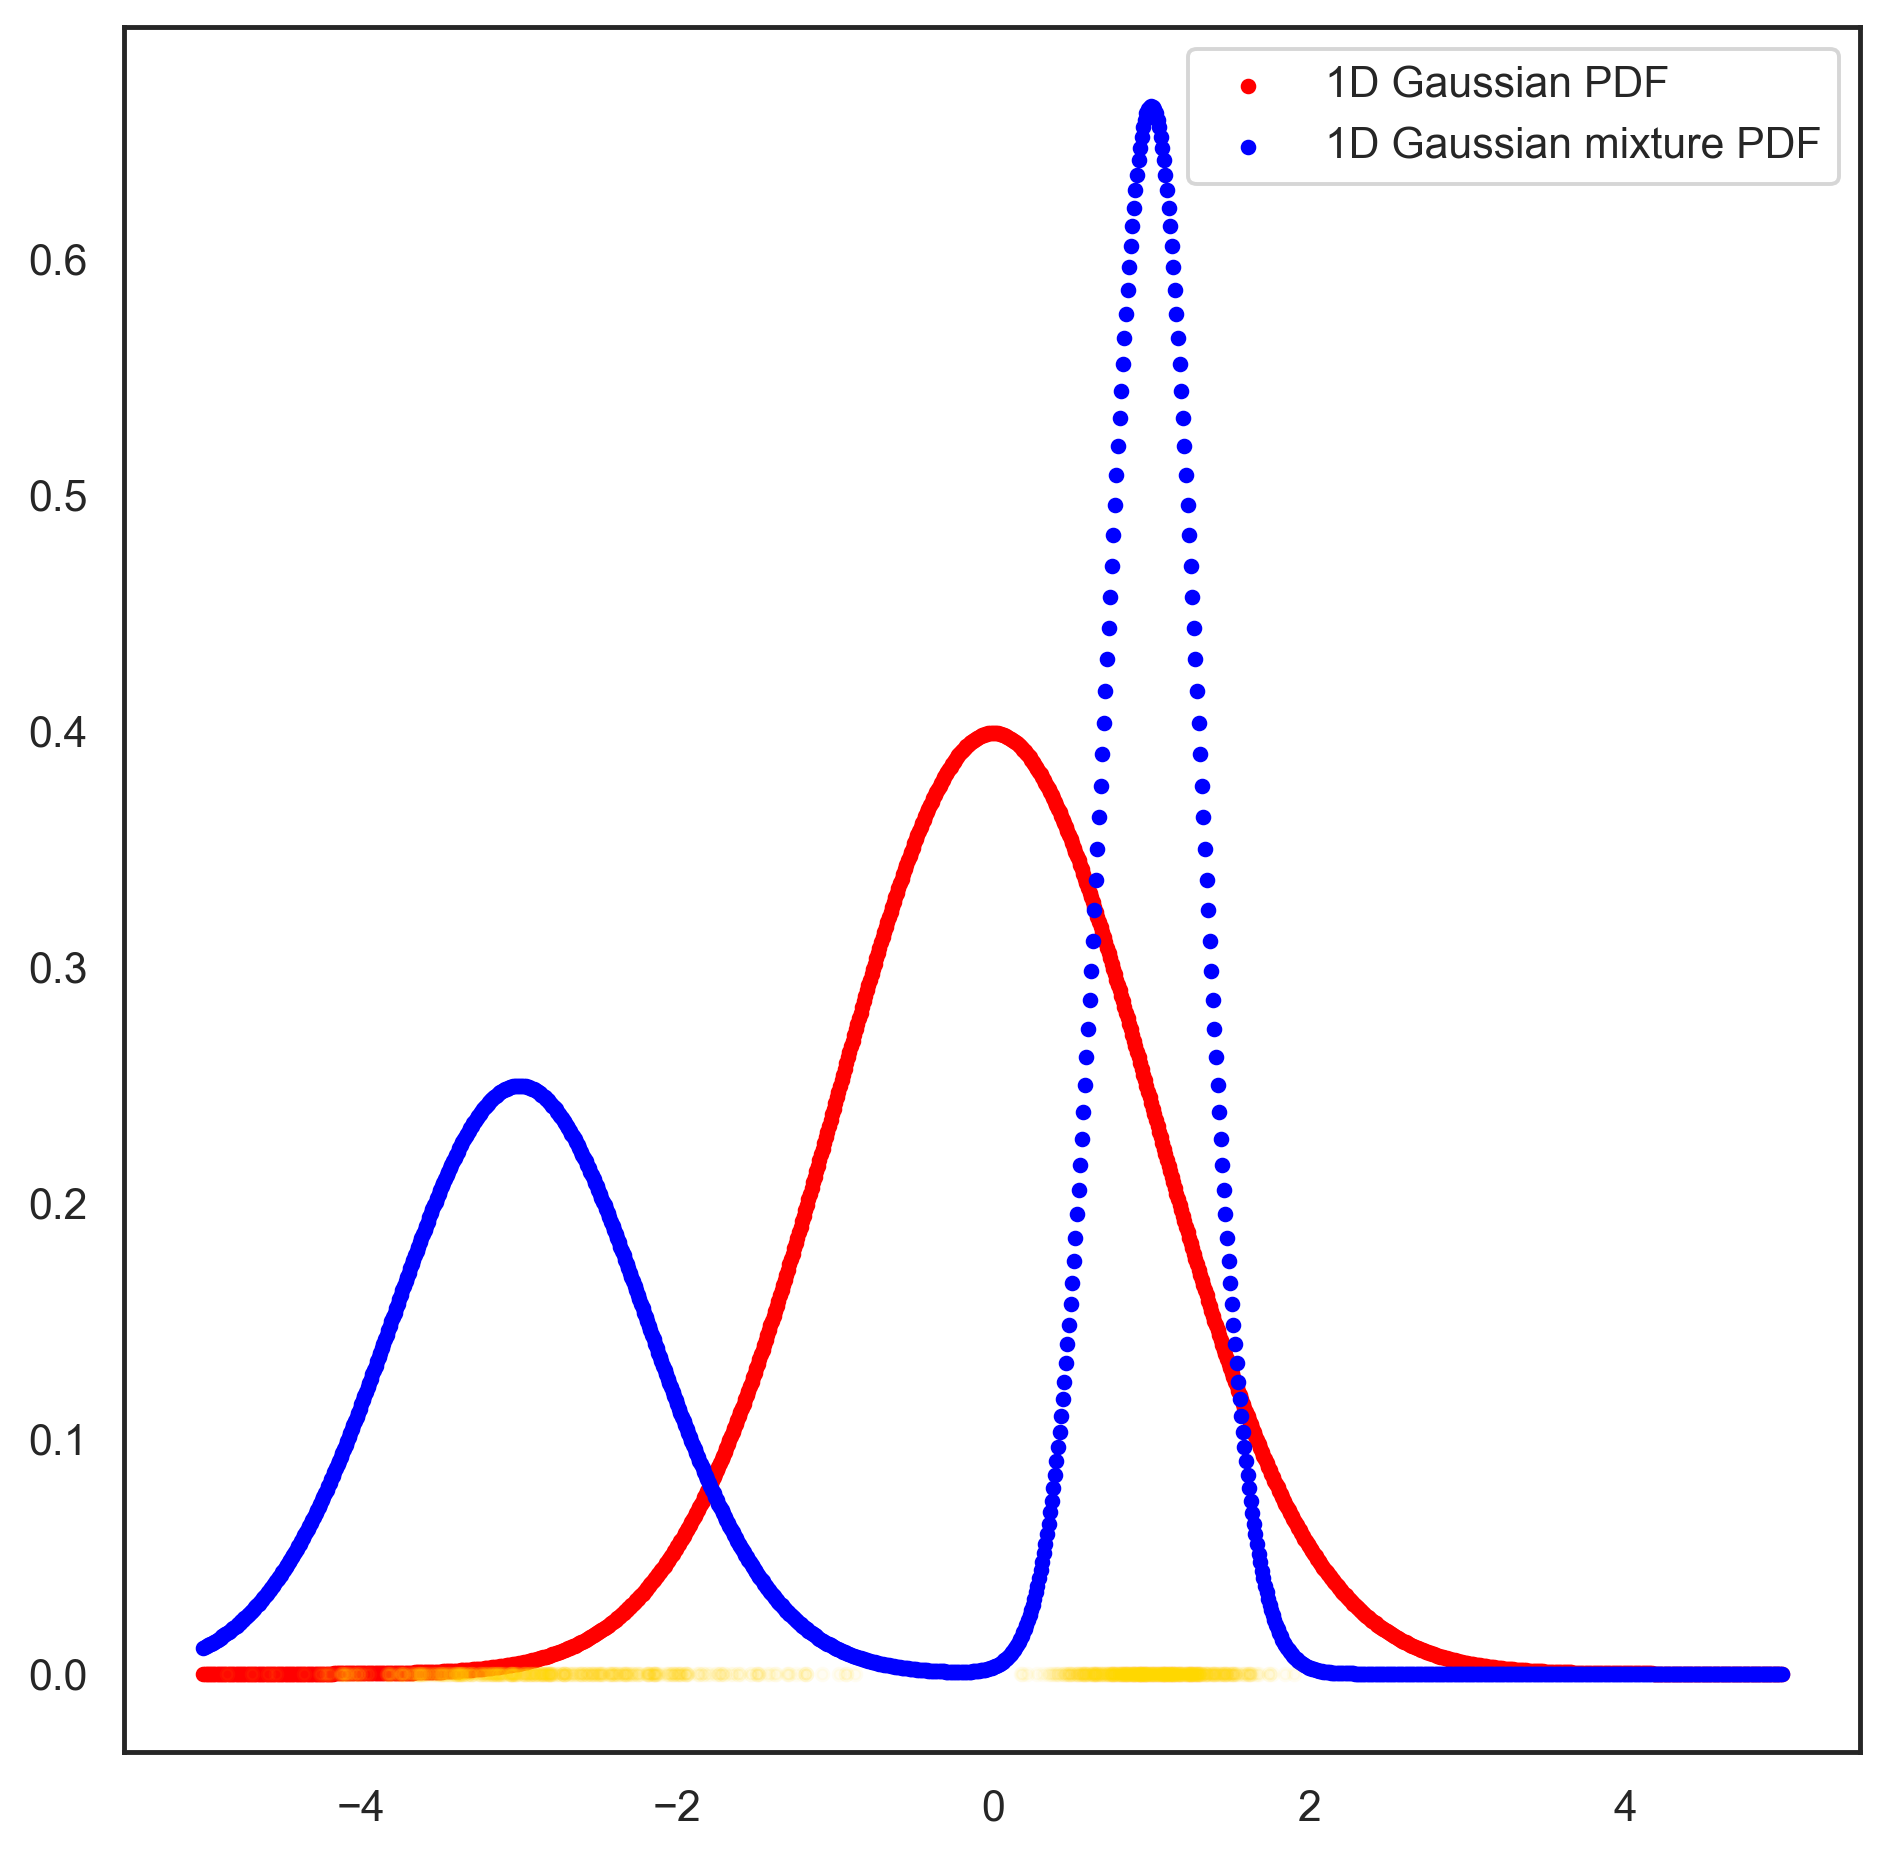

In [30]:
def plot_on_x(ax, x, **kwargs):
    ax.scatter(x, np.zeros_like(x), **kwargs)


key, *sub_keys = jax.random.split(key, 1000 + 1)
sub_keys = jnp.array(sub_keys)
fn = sampling_importance_resampling(hard, easy, 1000)
jitted = jax.jit(jax.vmap(fn, in_axes=(0, None, None)))
_, samples = jitted(sub_keys, mix_args, d_args)
plot_on_x(ax, samples, color="gold", marker=".", alpha=0.05)
fig

Notice what happens with the SIR samples (in gold)?

They accumulate around the places you'd expect to see if you were sampling from the `hard` distribution!

That's what importance sampling and sampling importance sampling give us - we provide a "hard" distribution with a `logpdf` interface, and another "easy" distribution with `sample` and `logpdf` interface^[There are more constraints. The second distribution must be _absolutely continuous_ in measure with respect to the first. Let's defer this discussion to a formal treatment of importance sampling.], and SIR returns an exact sampler for a distribution which approximates the hard distribution.

### Back to our generative function

Now that we've seen the ingredients and implementation of importance sampling and sampling importance resampling - let's return to our original problem.

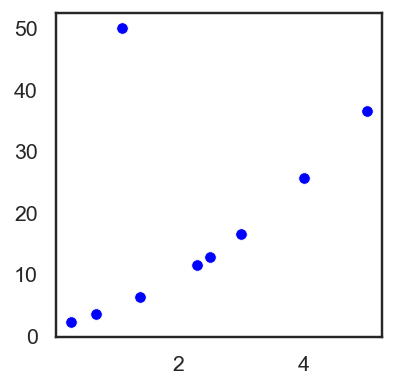

In [31]:
fig_data

If you studied the previous section careful - one question might jump out at you: what is the "easy" distribution for `model.importance`?

#### Builtin proposals

Generative functions defined using the `BuiltinGenerativeFunction` language come with builtin proposals - it's a distribution (which we'll refer to as $Q$) induced from the prior, with sampling and `score` defined ancestrally.

Give observation constraints $u$, the importance weight which `model.importance` computes is^[This definition again considers "untraced randomness" $r$. If you wish to ignore this in the math, just remove the $Q(r; x, \tau)$ term. Even in the presence of untraced randomness, the weights which Gen computes are asymptotically consistent in expectation over $Q(r; x, \tau)$]:

$$
\begin{align}
\log w &= \log P(\tau, r; x) - \log Q(\tau; u, x)Q(r; x, \tau) \\
\end{align}
$$

For the `BuiltinGenerativeFunction` language, we implement $Q$ by invoking the generative function - when we arrive at a constrained address, we recursively called `submodel.importance` - accumulate the log weight, as well as the log score.

Now, if an address has no constraints - we get `0.0` for the weight (think about why this is by looking at the above equation and asking what happens when $Q$ has to generate a full $\tau$). However, we still get a score.

#### Sequential importance resampling in GenJAX

Here's SIR using builtin proposals (just a single call to `model.importance`) in GenJAX^[To implement a variant with custom proposals, all we need to do is first `proposal.simulate`, merge the proposal choice map with the constraints, then `model.importance` followed by a final weight adjustment `w = w - proposal_tr.get_score()` - easy peasy.]:

In [32]:
def sampling_importance_resampling(model, n_samples):
    def _inner(key, observations, model_args):
        key, *sub_keys = jax.random.split(key, n_samples + 1)
        sub_keys = jnp.array(sub_keys)
        vmapped = jax.vmap(model.importance, in_axes=(0, None, None))
        _, (lws, trs) = vmapped(sub_keys, observations, model_args)
        key, sub_key = jax.random.split(key)
        index = genjax.TFPCategorical.sample(sub_key, lws)
        final_tr = jtu.tree_map(lambda v: v[index], trs)
        return key, final_tr

    return _inner

One difference between our first implementation (on just distributions) above and this one is that `Trace` instances are structured objects (but all of them are `Pytree` implementors) - meaning we need to index into the leaves when we wish to return a single sampled trace.

In [33]:
model_args = (x,)
jitted = jax.jit(
    jax.vmap(
        sampling_importance_resampling(model, 100), in_axes=(0, None, None)
    )
)
key, *sub_keys = jax.random.split(key, 100 + 1)
sub_keys = jnp.array(sub_keys)
_, samples = jitted(sub_keys, observations, model_args)
coefficients = samples["alpha"]

So now we have an approximate sampler for the posterior and we can use it to look at properties of the posterior - like what sort of curves are likely given our data and our model prior.

... and by the way, to get a representative set of samples from the posterior for this model, on an Apple M2 device - only takes about 0.05 seconds^[Just remember: we're running this notebook on CPU - but the resulting specialized inference code can easily be moved to accelerators, courtesy of the fact that all our code is JAX traceable.].

In [34]:
%%timeit
_, samples = jitted(sub_keys, observations, model_args)

57 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
def polynomial_at_x(x, coefficients):
    basis_values = jnp.array([1.0, x, x**2])
    polynomial_value = jnp.sum(coefficients * basis_values)
    return polynomial_value


jitted = jax.jit(jax.vmap(polynomial_at_x, in_axes=(None, 0)))

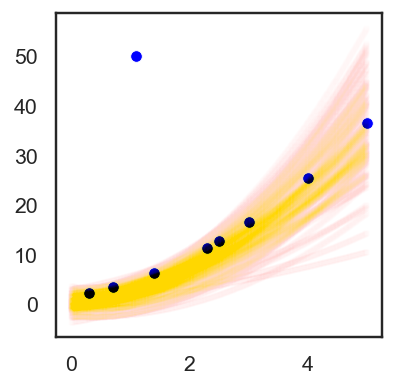

In [36]:
def plot_polynomial_values(ax, x, coefficients, **kwargs):
    v = jitted(x, coefficients)
    ax.scatter(np.repeat(x, len(v)), v, **kwargs)


coefficients = samples["alpha"]
evaluation_points = np.arange(0, 5, 0.01)
for data in evaluation_points:
    plot_polynomial_values(
        ax_data, data, coefficients, marker=".", color="gold", alpha=0.005
    )
fig_data

Intuitively, this makes a lot of sense. Our prior over polynomials considers a wide range of curves - but, if our approximate sampling process is trusted, we're correctly seeing what we should expect to happen if we observed this data - polynomials with the coefficients shown above tend to be sampled more under the posterior.

We can also ask for an estimate of the posterior probability that any particle point was an outlier. 

For example, below is the set of samples projected onto the `("ys", "outlier")` address for the point which we manually set to be quite far from the curve.

In [37]:
posterior_outlier = samples["ys", "outlier"][:, 2]
posterior_outlier

DeviceArray([ True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True, False,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True], dtype=bool)

In [38]:
np.sum(posterior_outlier) / len(posterior_outlier)

DeviceArray(0.99, dtype=float32)

That seems to make sense! We pulled that point quite far away from ground truth curve - so we'd expect that point 2 is considered an outlier under the true posterior.

## Summary

We've covered a lot of ground in this notebook. Please reflect, re-read, and post issues!

* We discussed the Gen probabilistic programming framework, and discussed GenJAX - an implementation of Gen on top of JAX. 
* We discussed _generative functions_ - the main computational object of Gen.
* We discussed how to create generative functions using _generative function languages_, and several of GenJAX's builtin capabilities for constructing generative functions.
* We discussed how to use generative functions to represent joint probability distributions, which can be used to construct models of phenomena.
* We created a generative function to model a data-generating process based on sampling and evaluating random polynomials at input data - to represent a typical regression task.
* We discussed how to formulate questions about induced conditional distributions under a probabilistic model as a Bayesian inference problem.
* We discussed importance sampling and sampling importance resampling, two central techniques in approximate Bayesian inference.
* We created a sampling importance resampling routine and applied it to produce approximate posterior samples from the posterior in the our polynomial generating model.
* We investigated the approximate posterior samples, and visually inspected that they match the inferences that we might draw - both for the polynomials we expected to produce the data, as well as what data points might be outliers.

This is just the beginning! There's a lot more to learn, but plenty to bite off with this initial notebook.